Author: Gianmarco Alessio

Department of Mathematics and Geosciences, University of Trieste, Italy

Course: Advanced Topics in Machine Learning, Fall 2023

Teacher: Prof. Fabio Anselmi

# Symmetry Regularization on MNIST dataset under rotation trasformation 

This is the first attempt to implement a Fully Connected 1 layer neural network (`number of neurons = 728`) multiclass classification problem that is invariant to the rotation of the MNIST dataset over a certain angle (in my analysis I selected an angle of 3 degree) and to compare the results with the same network but with different regularization terms, in particular:

- the *FCNN* with only the cross entropy loss. (**The CE LOSS**)
- the *FCNN* with the cross entropy loss and the regularization term for the challenge (**The Challenge LOSS**)
- the *FCNN* with the cross entropy loss and the Symmetry-Adapted Regularization terms (**The Symmetry LOSS**)


#### *Challenge 2*: *Discovering **Symmetries** in Data*

Advanced Topics in Machine Learning -- Fall 2023, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

Generate a dataset composed by rotations of 2-dimensional vectors *w.r.t.* a finite subgroup of the rotation group (*e.g.* every 3-4 degrees). Shuffle the dataset.  
Generate the labels according to the orbits.  

Implement a *NN* with one *FC* layer and `ReLU` to classify the orbits elements according to the label.  

Write a Loss that contains 3 terms:

- The regularization term as explained in class using [*soft-sort*](https://github.com/google-research/fast-soft-sort) on rows and columns of the Gramian of the first layer weights; (risp: `use_reg_sort` )
- The cross entropy entropy with orbit labels; (risp: `self.cross_entropy = nn.CrossEntropyLoss()`)
- The norm of the commutator between the covariance matrix of the data and that of the weights, as explained in class.  (risp: `use_reg_commutator`)

We are encouraged to come up with other constraints instead of *1* and especially *3*.  
(risp: instead of *1*  come up with `symmetry_reg_loss = symm_loss(atoms, cardinality, sigma_squared=0.001)` and instead of *2* I come up with `symmetry_comm_loss = comm_loss_function(atoms,train_images)` where i found them in the paper linked below )

In seeking alternatives to constraints *1* and especially *3*, I propose adopting two novel constraints derived from the research findings detailed in the referenced paper. For constraint *1*, I introduce a symmetry regularization loss, denoted as `symmetry_reg_loss`. This loss function is defined by `symm_loss(atoms, cardinality, sigma_squared=0.001)`, where it leverages the concept of symmetry in the representation space to enforce structural coherence. For the alternative to constraint *3*, I suggest the implementation of a symmetry commutator loss, `symmetry_comm_loss`. This is articulated through `comm_loss_function(atoms, train_images)`. 
The proposed constraints, inspired by methodologies detailed in the referenced paper, are designed to enhance the learning process through a focus on symmetry and communication within the model's structure. This approach, referred to as "Symmetry-Adapted Regularization," aims to incorporate symmetry principles directly into the regularization process

Test the invariance of the representation and plot the Gramian of the learned weights. 
We se matrix that manifest symmetries property in particular rotation invariance.



In [1]:
import torch
from torchvision import datasets, transforms
from torchvision import utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch import nn
from fast_soft_sort.pytorch_ops import soft_rank
from fast_soft_sort.pytorch_ops import soft_sort
import random
import numpy as np
# donwload the .py file
import functions
from functions import *

/Users/Giammi/5_dssc/second/atml/adv-ml-units/project/fast_soft_sort/third_party/isotonic.py:39: UserWarning: Numba could not be imported. Code will run much more slowly. To install, please run 'pip install numba'.
  warnings.warn("Numba could not be imported. Code will run much more slowly."


In [2]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=6000, shuffle=False)

test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)


for data, target in train_loader:
    train_images = data
    train_target = target
for data, target in test_loader:
    test_images = data
    test_target = target

rotated_train_images, rotated_train_labels, atoms, cardinality = rotate_images(train_images, train_target,angle=3)
rotated_test_images, rotated_test_labels, _, _ = rotate_images(test_images, test_target,angle=3)

In [3]:
rotated_train_dataset = torch.utils.data.TensorDataset(rotated_train_images, rotated_train_labels)
rotated_train_loader = DataLoader(rotated_train_dataset, batch_size=6120,shuffle=True) 
rotated_test_dataset = torch.utils.data.TensorDataset(rotated_test_images, rotated_test_labels)
rotated_test_loader = DataLoader(rotated_test_dataset, batch_size=1120,shuffle=True) 
for data, target in rotated_train_loader:
    train_images = data
    train_labels = target
for data, target in rotated_test_loader:
    test_images = data
    test_labels = target

In [4]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.fc(x)
        x = torch.relu(x)
        return x

In [5]:
class loss_function(nn.Module):
    def __init__(self, lambda_reg=0.01, lambda_symm=0.01,lambda_comm=0.01,lambda_symm_comm=0.01):
        super(loss_function, self).__init__()
        self.lambda_sort = lambda_reg
        self.lambda_symm = lambda_symm
        self.lambda_comm = lambda_comm
        self.lambda_symm_comm = lambda_symm_comm
        self.cross_entropy = nn.CrossEntropyLoss()
        self.atoms = nn.Parameter(torch.randn(120,748)) 

    def forward(self, prediction, labels, weights,train_images, use_reg_sort=False, use_reg_comm=False, use_symm_loss=False, use_symm_comm=False):

        reg_loss = 0 
        symmetry_reg_loss = 0 
        ce_loss = self.cross_entropy(prediction, labels)

        total_loss = ce_loss

        if use_reg_sort:
            reg_loss = reg_loss_function(weights)
            total_loss += self.lambda_sort * reg_loss

        if use_reg_comm:
            comm_loss = comm_loss_function(weights,train_images)
            total_loss += self.lambda_comm * comm_loss


        if use_symm_loss:
            symmetry_reg_loss = symm_loss(atoms, cardinality, sigma_squared=0.001)
            total_loss += self.lambda_symm * symmetry_reg_loss

        if use_symm_comm:
            symmetry_comm_loss = comm_loss_function(atoms,train_images)
            total_loss += self.lambda_symm_comm * symmetry_comm_loss
        

        return total_loss

Epoch [1/1000], Loss: 2.2997982501983643
Epoch [2/1000], Loss: 2.2815632820129395
Epoch [3/1000], Loss: 2.2646050453186035
Epoch [4/1000], Loss: 2.248584508895874
Epoch [5/1000], Loss: 2.2324540615081787
Epoch [6/1000], Loss: 2.215717315673828
Epoch [7/1000], Loss: 2.1985628604888916
Epoch [8/1000], Loss: 2.181516647338867
Epoch [9/1000], Loss: 2.1647660732269287
Epoch [10/1000], Loss: 2.14855694770813
Epoch [11/1000], Loss: 2.1328704357147217
Epoch [12/1000], Loss: 2.1176815032958984
Epoch [13/1000], Loss: 2.102945327758789
Epoch [14/1000], Loss: 2.0884742736816406
Epoch [15/1000], Loss: 2.0742831230163574
Epoch [16/1000], Loss: 2.0603959560394287
Epoch [17/1000], Loss: 2.0468506813049316
Epoch [18/1000], Loss: 2.0336718559265137
Epoch [19/1000], Loss: 2.0208919048309326
Epoch [20/1000], Loss: 2.00852632522583
Epoch [21/1000], Loss: 1.996580719947815
Epoch [22/1000], Loss: 1.9850447177886963
Epoch [23/1000], Loss: 1.9739001989364624
Epoch [24/1000], Loss: 1.963120698928833
Epoch [25/1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [983/1000], Loss: 1.0888962745666504
Epoch [984/1000], Loss: 1.0886785984039307
Epoch [985/1000], Loss: 1.0884616374969482
Epoch [986/1000], Loss: 1.0882439613342285
Epoch [987/1000], Loss: 1.0880244970321655
Epoch [988/1000], Loss: 1.0878056287765503
Epoch [989/1000], Loss: 1.0875871181488037
Epoch [990/1000], Loss: 1.0873693227767944
Epoch [991/1000], Loss: 1.0871522426605225
Epoch [992/1000], Loss: 1.0869359970092773
Epoch [993/1000], Loss: 1.086720585823059
Epoch [994/1000], Loss: 1.0865057706832886
Epoch [995/1000], Loss: 1.0862919092178345
Epoch [996/1000], Loss: 1.0860787630081177
Epoch [997/1000], Loss: 1.0858664512634277
Epoch [998/1000], Loss: 1.0856549739837646
Epoch [999/1000], Loss: 1.0854443311691284
Epoch [1000/1000], Loss: 1.0852344036102295


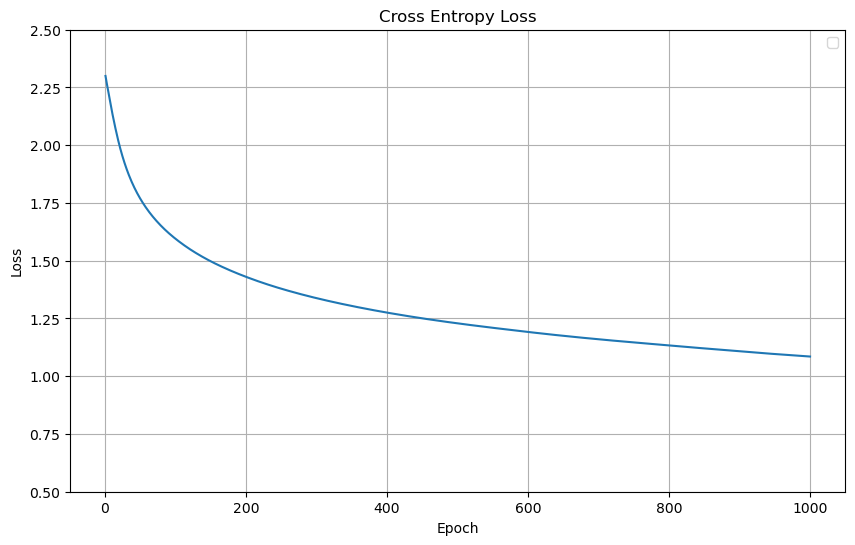

In [6]:
net = Net(784, 10)
loss_value = loss_function()
optimizer = torch.optim.Adam([
    {'params': net.parameters()},
    {'params': loss_value.parameters()}  # Assumi che loss_function sia l'istanza della tua classe loss_function
], lr=0.001)

num_epochs = 1000
loss_history = []  # To store loss values

for epoch in range(num_epochs):

    train_images = train_images.view(train_images.shape[0], -1)
    optimizer.zero_grad()

    # Forward pass
    prediction = net(train_images)
    weights = net.fc.weight # i pesi del layer
    loss = loss_value(prediction, train_labels, weights,train_images, use_reg_sort=False, use_reg_comm=False, use_symm_loss=False, use_symm_comm=False)

    # Backward pass e ottimizzazione
    loss.backward()
    optimizer.step()

    # Store the loss for plotting
    loss_history.append(loss.item())

    # Stampa la perdita per ogni epoca
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

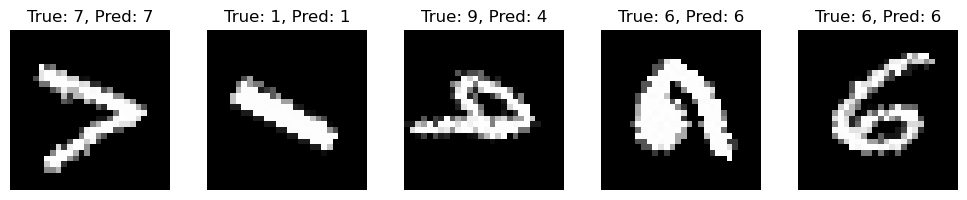

Train Accuracy: 65.94771241830065%


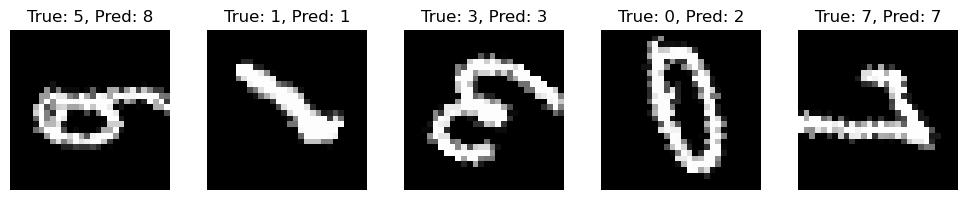

Test Accuracy: 52.23214285714286%


In [7]:
# Inizializza il modello
#net = Net(784, 10)
#best_model_params = torch.load('./best_model_weights/symmetry_loss.pth')
#net.load_state_dict(best_model_params)

train_accuracy = calculate_accuracy(net, rotated_train_loader)
print(f'Train Accuracy: {train_accuracy * 100}%')
test_accuracy = calculate_accuracy(net, rotated_test_loader)
print(f'Test Accuracy: {test_accuracy * 100}%')

In [8]:
differences = []
differences_control = []

control_img = None

for i, (images, label) in enumerate(test_loader):
    # The order is the same due to the fact that both dataloaders are not shuffled!
    (images_rot, label_rot) = rotated_test_loader.__iter__().__next__()

    if i == 0:
        control_img = torch.randn_like(images)

    # Example of flattening the input
    images = images.view(images.size(0), -1) # Flatten the images
    images_rot = images_rot.view(images_rot.size(0), -1) # Flatten the images
    control_img = control_img.view(control_img.size(0), -1) # Flatten the images

    act = get_activations(images, net, "fc")
    act_rot = get_activations(images_rot, net, "fc")
    act_control = get_activations(control_img, net, "fc")

    # When the non-augmented dataset is over, the rest of the batch is eventually filled with augmentations
    # This check (and fix) avoids dimension mismatches
    if act.shape[0] != act_rot.shape[0]:
        act_rot = act_rot[: act.shape[0]]
        act_control = act_control[: act.shape[0]]

    differences.append(act - act_rot)
    differences_control.append(act - act_control)

    control_img = images_rot
 
avg_norm = torch.linalg.norm(torch.cat(differences, dim=0), dim=1).mean()
avg_norm_control = torch.linalg.norm(torch.cat(differences_control, dim=0), dim=1).mean()

print(f"Average Euclidean norm of the difference: {avg_norm.item()}")
print(f"Average Euclidean norm of the difference, control: {avg_norm_control.item()}")

Average Euclidean norm of the difference: 14.742980003356934
Average Euclidean norm of the difference, control: 16.557146072387695


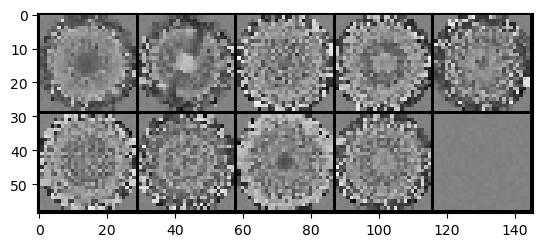

torch.Size([10, 784])
tensor([[ 0.0301, -0.0055,  0.0174,  ..., -0.0011, -0.0331,  0.0092],
        [ 0.0048,  0.0102, -0.0279,  ...,  0.0172,  0.0256,  0.0260],
        [-0.0133, -0.0232, -0.0170,  ..., -0.0190,  0.0122,  0.0315],
        ...,
        [ 0.0195, -0.0213, -0.0341,  ..., -0.0342, -0.0051, -0.0340],
        [ 0.0183, -0.0151, -0.0316,  ...,  0.0347,  0.0344,  0.0191],
        [ 0.0008, -0.0072,  0.0147,  ..., -0.0059, -0.0121, -0.0250]])


In [9]:
# Extracting weights
weights = net.fc.weight.detach().cpu()

# Normalization
w_min, w_max = weights.min(), weights.max()
plt_weights = (weights - w_min) / (w_max - w_min)


# Reshape weights for a 5x5 grid, assuming each weight vector is of size 28*28
# You need to ensure that there are at least 25 weight vectors
plt_weights = plt_weights[:25].reshape(-1, 1, 28, 28)  # Taking first 25 weight vectors

# Create a 5x5 grid
grid = utils.make_grid(plt_weights, nrow=5, normalize=True, padding=1)
plt.imshow(grid.permute(1, 2, 0))  # Permute the axes to display the image correctly
plt.show()

# Print weight information
print(weights.shape)
print(weights)


In [ ]:
# PER Il PLOT

best_loss = float('inf')
best_params = None
all_losses = []  # Per memorizzare tutte le curve di perdita
num_epochs = 1000
num_runs = 10

for run in range(num_runs):
    net = Net(784, 10)  # Re-inizializza la rete per ogni run
    loss_value = loss_function()
    optimizer = torch.optim.Adam([
        {'params': net.parameters()},
        {'params': loss_value.parameters()}
    ], lr=0.001)

    loss_history = []  # Per memorizzare i valori di perdita di questa esecuzione

    for epoch in range(num_epochs):
        train_images = train_images.view(train_images.shape[0], -1)
        optimizer.zero_grad()

        prediction = net(train_images)
        weights = net.fc.weight
        loss = loss_value(prediction, train_labels, weights, train_images,
                          use_reg_sort=False, use_reg_comm=False,
                          use_symm_loss=True, use_symm_comm=True)

        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

    all_losses.append(loss_history)  # Aggiungi la storia di perdita di questa esecuzione alla lista generale

    # Verifica se questa esecuzione ha la migliore perdita media
    avg_loss = np.mean(loss_history)
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = net.state_dict()  # Salva i parametri della rete

# Calcolare la media delle perdite per ogni epoca
mean_losses = np.mean(all_losses, axis=0)

# Plotting tutte le curve di perdita e la media
plt.figure(figsize=(10, 6))
for i, loss_history in enumerate(all_losses):
    plt.plot(range(1, num_epochs + 1), loss_history, label=f'Run {i+1}', alpha=0.5)
plt.plot(range(1, num_epochs + 1), mean_losses, color='black', label='Mean Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Symmetry LOSS Over 10 Runs')
plt.legend()
plt.grid(True)
plt.ylim([0.5, 2.5])
plt.show()

# Salvare i migliori parametri della rete
torch.save(best_params, 'best_model_params.pth')
